# Sales Prediction with ML models

In [49]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
#load the data
data = pd.read_csv("Advertising.csv")

In [5]:
data.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [36]:
data = data.drop('Unnamed: 0', axis=1)

In [72]:
# data shape
data.shape


(198, 4)

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         198 non-null    float64
 1   Radio      198 non-null    float64
 2   Newspaper  198 non-null    float64
 3   Sales      198 non-null    float64
dtypes: float64(4)
memory usage: 7.7 KB


In [38]:
data.describe()

,TV,Radio,Newspaper,Sales
count,198.000000,198.000000,198.000000,198.000000
mean,146.688384,23.130808,29.777273,13.980808
std,85.443221,14.862111,20.446303,5.196097
min,0.700000,0.000000,0.300000,1.600000
25%,74.800000,9.925000,12.650000,10.325000
50%,149.750000,22.400000,25.600000,12.900000
75%,218.475000,36.325000,44.050000,17.375000
max,293.600000,49.600000,89.400000,27.000000


In [39]:
#checking for missing values
data.isnull().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

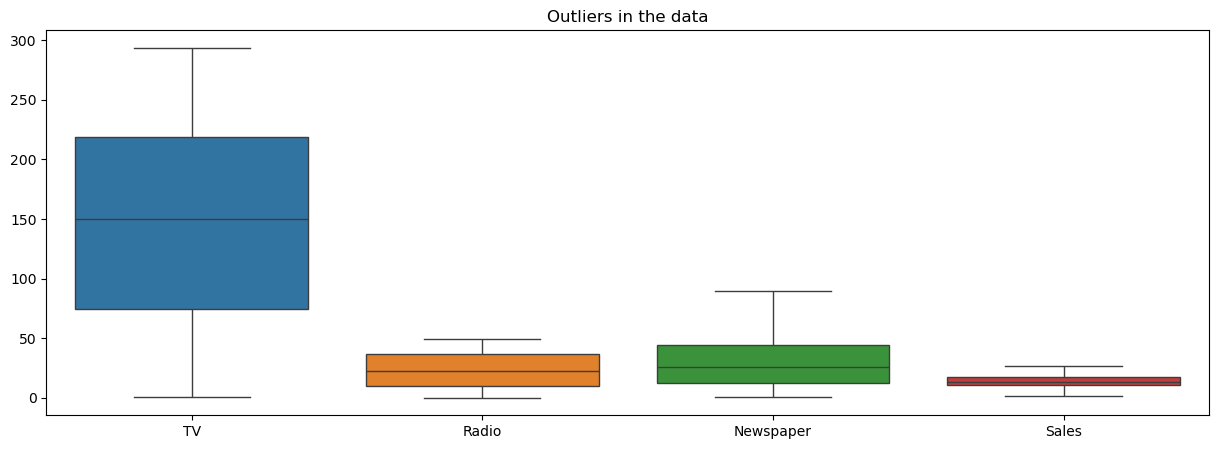

In [40]:
#check for outliers
plt.figure(figsize=(15, 5))
sns.boxplot(data=data)
plt.title("Outliers in the data")
plt.show()

In [41]:
#Detect and remove outliers using IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

In [42]:
# Filtering out the outliers
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
print(data.describe())

               TV       Radio   Newspaper       Sales
count  198.000000  198.000000  198.000000  198.000000
mean   146.688384   23.130808   29.777273   13.980808
std     85.443221   14.862111   20.446303    5.196097
min      0.700000    0.000000    0.300000    1.600000
25%     74.800000    9.925000   12.650000   10.325000
50%    149.750000   22.400000   25.600000   12.900000
75%    218.475000   36.325000   44.050000   17.375000
max    293.600000   49.600000   89.400000   27.000000


C:\Users\Admin\.conda\envs\dl_08\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


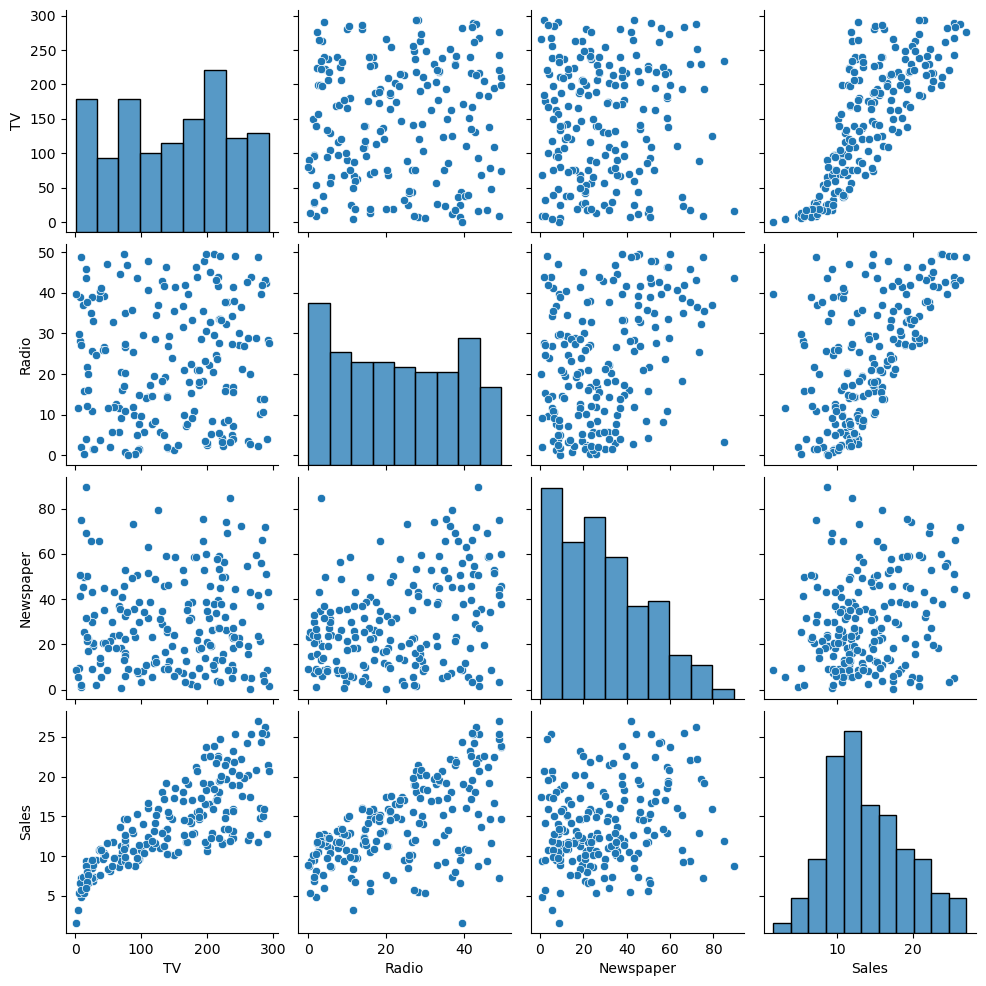

In [43]:
sns.pairplot(data)
plt.show()

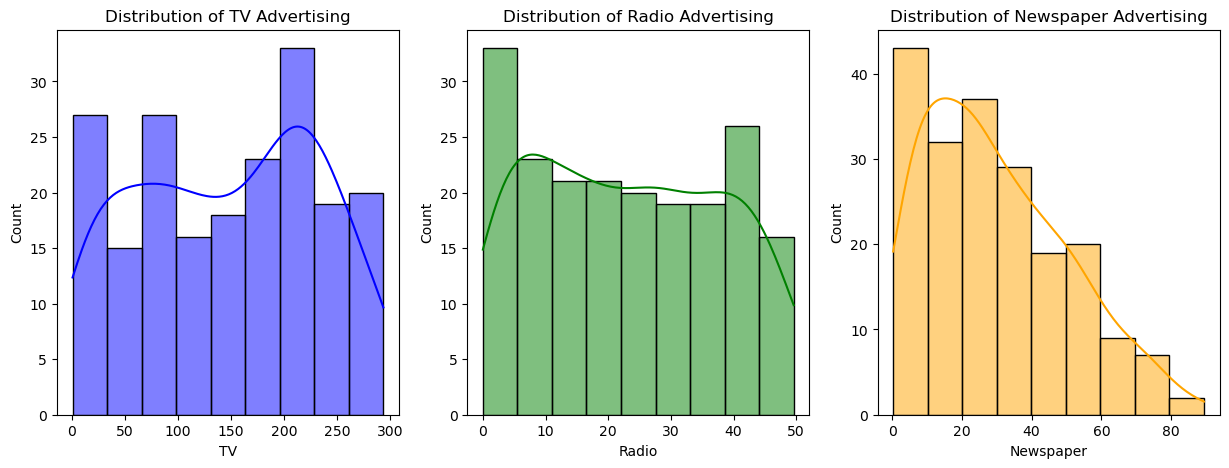

In [48]:
# Plot histograms for independent variables
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(data['TV'], kde=True, color='blue')
plt.title('Distribution of TV Advertising')

plt.subplot(1, 3, 2)
sns.histplot(data['Radio'], kde=True, color='green')
plt.title('Distribution of Radio Advertising')

plt.subplot(1, 3, 3)
sns.histplot(data['Newspaper'], kde=True, color='orange')
plt.title('Distribution of Newspaper Advertising')

plt.show()

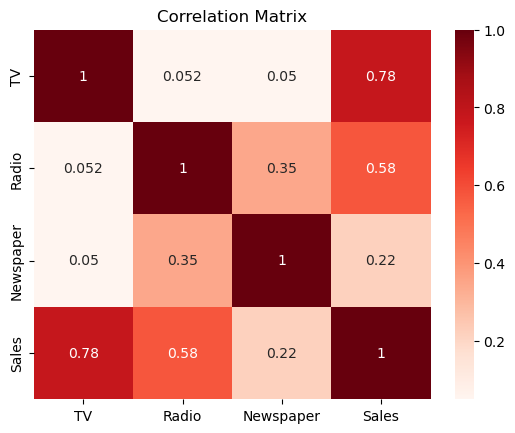

In [74]:
# Correlation heatmap
sns.heatmap(data.corr(), annot=True, cmap='Reds')
plt.title('Correlation Matrix')
plt.show()

In [45]:
# Define features and target variable
X = data.drop(columns=['Sales'])
y = data['Sales']

In [46]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [54]:
#Define models and hyperparameter grids
models = {
    'Linear Regression': (LinearRegression(), None),
    'Random Forest': (RandomForestRegressor(random_state=42), {
        'Random Forest__n_estimators': [50, 100, 200],
        'Random Forest__max_depth': [None, 10, 20, 30],
        'Random Forest__min_samples_split': [2, 5, 10]
    }),
    'XGBoost': (XGBRegressor(random_state=42, objective='reg:squarederror'), {
        'XGBoost__n_estimators': [50, 100, 200],
        'XGBoost__learning_rate': [0.01, 0.1, 0.2],
        'XGBoost__max_depth': [3, 6, 10]
    })
}

In [55]:
# Train and evaluate models
results = {}

for model_name, (model, param_grid) in models.items():
    print(f"Training {model_name}...")
    pipeline = Pipeline(steps=[
        ("scaler", StandardScaler()),
        (model_name, model)
    ])

    if param_grid:
        # Use GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="r2")
        grid_search.fit(X_train, y_train)

        # Evaluate the model
        y_pred = grid_search.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Store results
        results[model_name] = {
            "Best Parameters": grid_search.best_params_,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R²": r2
        }
    else:
        # No hyperparameter tuning for models without param_grid
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Store results
        results[model_name] = {
            "Best Parameters": "N/A",
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R²": r2
        }

Training Linear Regression...
Training Random Forest...
Training XGBoost...


In [56]:
# Sort and display results
sorted_results = sorted(results.items(), key=lambda x: x[1]["RMSE"])

print("\nModel Evaluation Results (Sorted by RMSE in Ascending Order):")
for model_name, result in sorted_results:
    print(f"{model_name}:")
    print(f"  Best Parameters: {result['Best Parameters']}")
    print(f"  MAE: {result['MAE']}")
    print(f"  MSE: {result['MSE']}")
    print(f"  RMSE: {result['RMSE']}")
    print(f"  R²: {result['R²']}")
    print()



Model Evaluation Results (Sorted by RMSE in Ascending Order):
Random Forest:
  Best Parameters: {'Random Forest__max_depth': 10, 'Random Forest__min_samples_split': 2, 'Random Forest__n_estimators': 100}
  MAE: 0.5437241666666704
  MSE: 0.4153459749583364
  RMSE: 0.6444734090389893
  R²: 0.9846866333509688

XGBoost:
  Best Parameters: {'XGBoost__learning_rate': 0.2, 'XGBoost__max_depth': 3, 'XGBoost__n_estimators': 50}
  MAE: 0.6723489665985107
  MSE: 0.652344798126882
  RMSE: 0.8076786478091902
  R²: 0.9759487374921421

Linear Regression:
  Best Parameters: N/A
  MAE: 1.2497394075236383
  MSE: 2.740911906689994
  RMSE: 1.6555699642993025
  R²: 0.8989454779619588



In [64]:
# Display the best model with all metrics
best_model_name = sorted_results[0][0]
best_model_result = sorted_results[0][1]
print("\nBest Model:")
print(f"{best_model_name}:")
print(f"  Best Parameters: {best_model_result['Best Parameters']}")
print(f"  MAE: {best_model_result['MAE']}")
print(f"  MSE: {best_model_result['MSE']}")
print(f"  RMSE: {best_model_result['RMSE']}")
print(f"  R²: {best_model_result['R²']}")



Best Model:
Random Forest:
  Best Parameters: {'Random Forest__max_depth': 10, 'Random Forest__min_samples_split': 2, 'Random Forest__n_estimators': 100}
  MAE: 0.5437241666666704
  MSE: 0.4153459749583364
  RMSE: 0.6444734090389893
  R²: 0.9846866333509688


In [71]:
#Evaluate the best model on the training set
if best_model_result["Best Parameters"] != "N/A":
    best_pipeline = GridSearchCV(Pipeline(steps=[
        ("scaler", StandardScaler()),
        (best_model_name, models[best_model_name][0])
    ]), param_grid=models[best_model_name][1], cv=5, scoring="r2")
    best_pipeline.fit(X_train, y_train)
else:
    best_pipeline = Pipeline(steps=[
        ("scaler", StandardScaler()),
        (best_model_name, models[best_model_name][0])
    ])
    best_pipeline.fit(X_train, y_train)

train_predictions = best_pipeline.predict(X_train)
train_mae = mean_absolute_error(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, train_predictions)

print("Best Model Evaluation on Training Set:")
print(f"  MAE: {train_mae}")
print(f"  MSE: {train_mse}")
print(f"  RMSE: {train_rmse}")
print(f"  R²: {train_r2}")

Best Model Evaluation on Training Set:
  MAE: 0.21663512658227718
  MSE: 0.0801354602725026
  RMSE: 0.28308207338597513
  R²: 0.9970081339950438


In [70]:
# Evaluate the best model on the test set
test_predictions = best_pipeline.predict(X_test)
test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_predictions)

print("Best Model Evaluation on Test Set:")
print(f"  MAE: {test_mae}")
print(f"  MSE: {test_mse}")
print(f"  RMSE: {test_rmse}")
print(f"  R²: {test_r2}")

Best Model Evaluation on Test Set:
  MAE: 0.5437241666666704
  MSE: 0.4153459749583364
  RMSE: 0.6444734090389893
  R²: 0.9846866333509688


### Conclusion and Analysis


**Model Selection:**

Among the models (Linear Regression, Random Forest, XGBoost), the one with the lowest RMSE is selected as the best-performing model. This ranking ensures the model minimizes prediction errors.

**Impact of Outlier Removal:**

Removing outliers improves model accuracy and ensures robust predictions. The cleaned dataset likely reduced variance and improved performance consistency.

**Model Performance Insights:**

Linear Regression may perform decently but lacks the flexibility to capture complex relationships.
Random Forest and XGBoost are better suited for handling non-linear relationships, and their performance is improved by hyperparameter tuning.

**Recommendation:**

The best model, as identified, should be used for predicting sales. Its parameters can be fine-tuned further if needed, or additional features could be explored to enhance accuracy.